# Start-to-Finish Example: $\text{GiRaFFE_HO}$ 1D tests

### Author: Patrick Nelson

### Adapted from [Start-to-Finish Example: Head-On Black Hole Collision](Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb)

## This module implements a basic GRFFE code to evolve one-dimensional GRFFE waves.

### NRPy+ Source Code for this module: 
1. [GiRaFFEfood_HO/GiRaFFEfood_HO_1D_tests.py](../edit/GiRaFFEfood_HO/GiRaFFEfood_HO_1D_tests.py); [\[**tutorial**\]](Tutorial-GiRaFFEfood_HO_1D_tests.ipynb): Aligned rotator initial data, sets all FFE variables in a Cartesian basis.
1. [GiRaFFE_HO/GiRaFFE_Higher_Order.py](../edit/GiRaFFE_HO/GiRaFFE_Higher_Order.py); [\[**tutorial**\]](Tutorial-GiRaFFE_Higher_Order.ipynb): Generates the right-hand sides for the GRFFE evolution equations in Cartesian coordinates.
We will also borrow C code from the ETK implementation of $\text{GiRaFFE_HO}$

Here we use NRPy+ to generate the C source code necessary to set up initial data for a model neutron star (see [the original GiRaFFE paper](https://arxiv.org/pdf/1704.00599.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. (**Step 2** below) <font color='green'>Set gridfunction values to initial data (**[documented in previous start-to-finish module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_two_BH_initial_data.ipynb)**).</font>
1. Evolve the initial data forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. (**Step 3A** below) <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. (**Step 4** below) Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
1. (**Step 3B** below) At the end of each iteration in time, output the <font color='green'>FFE variables</font>. (This is in Step 3B, because Step 4 requires that *all* gridfunctions be defined.)
1. Repeat above steps at two numerical resolutions to confirm convergence to the expected value.

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

# Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 2)

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Cartesian")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Then we set the phi axis to be the symmetry axis; i.e., axis "2", corresponding to the i2 direction. 
#      This sets all spatial derivatives in the phi direction to zero.
#par.set_parval_from_str("indexedexp::symmetry_axes","2") # Let's not deal with this yet.

#################
# Next output C headers related to the numerical grids we just set up:
#################

# Create directories for the thorn if they don't exist.
!mkdir GiRaFFE_standalone 2>/dev/null # 2>/dev/null: Don't throw an error if the directory already exists.

# First output the coordinate bounds xxmin[] and xxmax[]:
with open("GiRaFFE_standalone/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")

# Next output the proper distance between gridpoints in given coordinate system.
#     This is used to find the minimum timestep.
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"GiRaFFE_standalone/ds_dirn.h")

# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "GiRaFFE_standalone/xxCart.h")

Wrote to file "GiRaFFE_standalone/ds_dirn.h"
Wrote to file "GiRaFFE_standalone/xxCart.h"


## Step 2A: Import Aligned Rotator initial data C function

The [GiRaFFEfood_HO.GiRaFFEfood_HO_AlignedRotator.py](../edit/GiRaFFEfood_HO/GiRaFFEfood_HO_AlignedRotator.py) NRPy+ module does the following:

1. Set up Aligned rotator initial data quantities in the **Cartesian basis**, as [documented here](Tutorial-GiRaFFEfood_HO_Aligned_Rotator.ipynb). 


In [2]:
import GiRaFFEfood_HO.GiRaFFEfood_HO_1D_tests as gf1D
gf1D.GiRaFFEfood_HO_1D_tests()

# Step 2: Create the C code output kernel.
#BU = ixp.register_gridfunctions_for_single_rank1("AUX","BU")
GiRaFFEfood_A_v_to_print_left   = [\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gf1D.AleftD[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gf1D.AleftD[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gf1D.AleftD[2]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU0"),rhs=gf1D.ValenciavleftU[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU1"),rhs=gf1D.ValenciavleftU[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU2"),rhs=gf1D.ValenciavleftU[2]),\
                                  ]
GiRaFFEfood_A_v_to_print_center = [\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gf1D.AcenterD[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gf1D.AcenterD[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gf1D.AcenterD[2]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU0"),rhs=gf1D.ValenciavcenterU[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU1"),rhs=gf1D.ValenciavcenterU[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU2"),rhs=gf1D.ValenciavcenterU[2]),\
                                  ]
GiRaFFEfood_A_v_to_print_right  = [\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gf1D.ArightD[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gf1D.ArightD[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gf1D.ArightD[2]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU0"),rhs=gf1D.ValenciavrightU[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU1"),rhs=gf1D.ValenciavrightU[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU2"),rhs=gf1D.ValenciavrightU[2]),\
                                  ]

GiRaFFEfood_A_v_CKernel_left   = fin.FD_outputC("returnstring",GiRaFFEfood_A_v_to_print_left,   params="outCverbose=False")
GiRaFFEfood_A_v_CKernel_center = fin.FD_outputC("returnstring",GiRaFFEfood_A_v_to_print_center, params="outCverbose=False")
GiRaFFEfood_A_v_CKernel_right  = fin.FD_outputC("returnstring",GiRaFFEfood_A_v_to_print_right,  params="outCverbose=False")

# Format the code within a C loop over cctkGH
#GiRaFFEfood_A_v_looped = loop.loop(["i2","i1","i0"],["0","0","0"],["cctk_lsh[2]","cctk_lsh[1]","cctk_lsh[0]"],\
#                                   ["1","1","1"],["#pragma omp parallel for","",""],"",\
#                                   GiRaFFEfood_A_v_CKernel.replace("time","cctk_time"))

# Step 4: Write the C code kernel to file.
with open("GiRaFFE_standalone/GiRaFFEfood_A_v_1D_tests_left.h", "w") as file:
    file.write(str(GiRaFFEfood_A_v_CKernel_left))

with open("GiRaFFE_standalone/GiRaFFEfood_A_v_1D_tests_center.h", "w") as file:
    file.write(str(GiRaFFEfood_A_v_CKernel_center))

with open("GiRaFFE_standalone/GiRaFFEfood_A_v_1D_tests_right.h", "w") as file:
    file.write(str(GiRaFFEfood_A_v_CKernel_right))


initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmax


## Step 2C: Import densitized Poynting flux initial data conversion C function

The [GiRaFFEfood_HO.GiRaFFEfood_HO.py](../edit/GiRaFFEfood_HO/GiRaFFEfood_HO.py) NRPy+ module does the following:

1. Set up Exact Wald initial data quantities in the **Cartesian basis**, as [documented here](Tutorial-GiRaFFEfood_HO_Aligned_Rotator.ipynb).
2. Convert initial magnetic fields and Valencia 3-velocities into densitized Poynting flux initial data.

We only use the second functionality here (for now).


In [3]:
# Step 2: Create the C code output kernel.
gri.glb_gridfcs_list = []
import GiRaFFEfood_HO.GiRaFFEfood_HO as gfho
gfho.GiRaFFEfood_HO_ID_converter()
# To best format this for the ETK, we'll need to register this gridfunction.
StildeD = ixp.register_gridfunctions_for_single_rank1("EVOL","StildeD")
GiRaFFE_S_to_print = [\
                      lhrh(lhs=gri.gfaccess("out_gfs","StildeD0"),rhs=gfho.StildeD[0]),\
                      lhrh(lhs=gri.gfaccess("out_gfs","StildeD1"),rhs=gfho.StildeD[1]),\
                      lhrh(lhs=gri.gfaccess("out_gfs","StildeD2"),rhs=gfho.StildeD[2]),\
                     ]

GiRaFFE_S_CKernel = fin.FD_outputC("returnstring",GiRaFFE_S_to_print,params="outCverbose=False")

# Format the code within a C loop over cctkGH
GiRaFFE_S_looped = lp.loop(["i2","i1","i0"],["0","0","0"],
                           ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],\
                           ["1","1","1"],["#pragma omp parallel for","",""],"",\
                           GiRaFFE_S_CKernel.replace("time","cctk_time"))

# Step 4: Write the C code kernel to file.
with open("GiRaFFE_standalone/GiRaFFEfood_HO_Stilde.h", "w") as file:
    file.write(str(GiRaFFE_S_looped))


initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmax


## Step 3A: Output BSSN RHS expressions

In [4]:
gri.glb_gridfcs_list = [] # This is necessary because, since this was originally designed as two ETK thorns,
                          # some gridfunctions are registered twice.

import GiRaFFE_HO.GiRaFFE_Higher_Order_v2 as gho
gho.GiRaFFE_Higher_Order_v2()

# Declaring StildeD as a gridfunction is unnecessary in GiRaFFE_HO. While it was declared in GiRaFFEfood_HO,
# those have since been cleared to avoid conflict; so, we re-declare it here.
StildeD = ixp.register_gridfunctions_for_single_rank1("EVOL","StildeD")

# Create the C code output kernel.
# Here, "Prereqs" refers to quantities that must be finite-difference to construct the RHSs.
Prereqs_to_print = [\
                   lhrh(lhs=gri.gfaccess("out_gfs","AevolParen"),rhs=gho.AevolParen),\
                   lhrh(lhs=gri.gfaccess("out_gfs","PevolParenU0"),rhs=gho.PevolParenU[0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","PevolParenU1"),rhs=gho.PevolParenU[1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","PevolParenU2"),rhs=gho.PevolParenU[2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD00"),rhs=gho.SevolParenUD[0][0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD01"),rhs=gho.SevolParenUD[0][1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD02"),rhs=gho.SevolParenUD[0][2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD10"),rhs=gho.SevolParenUD[1][0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD11"),rhs=gho.SevolParenUD[1][1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD12"),rhs=gho.SevolParenUD[1][2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD20"),rhs=gho.SevolParenUD[2][0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD21"),rhs=gho.SevolParenUD[2][1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD22"),rhs=gho.SevolParenUD[2][2]),\
                   ]

metric_quantities_to_print = [\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU00"),rhs=gho.gammaUU[0][0]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU01"),rhs=gho.gammaUU[0][1]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU02"),rhs=gho.gammaUU[0][2]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU11"),rhs=gho.gammaUU[1][1]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU12"),rhs=gho.gammaUU[1][2]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU22"),rhs=gho.gammaUU[2][2]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammadet"),rhs=gho.gammadet),\
                             ]

# To best format this for the ETK, we'll need to register these gridfunctions.
#Stilde_rhsD = ixp.register_gridfunctions_for_single_rank1("AUX","Stilde_rhsD")
#A_rhsD = ixp.register_gridfunctions_for_single_rank1("AUX","A_rhsD")
#psi6Phi_rhs = gri.register_gridfunctions("AUX","psi6Phi_rhs")
Conservs_to_print = [\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","StildeD0"),rhs=gho.Stilde_rhsD[0]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","StildeD1"),rhs=gho.Stilde_rhsD[1]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","StildeD2"),rhs=gho.Stilde_rhsD[2]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AD0"),rhs=gho.A_rhsD[0]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AD1"),rhs=gho.A_rhsD[1]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AD2"),rhs=gho.A_rhsD[2]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","psi6Phi"),rhs=gho.psi6Phi_rhs),\
                    ]

import time
print("Generating C code for GiRaFFE RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
start = time.time()

Prereqs_CKernel = fin.FD_outputC("returnstring",Prereqs_to_print,params="outCverbose=False")
#Prereqs_CKernel = "const double u0 = u0GF[CCTK_GFINDEX3D(cctkGH, i0,i1,i2)];\n" + Prereqs_CKernel
metric_quantities_CKernel = fin.FD_outputC("returnstring",metric_quantities_to_print,params="outCverbose=False")
Conservs_CKernel = fin.FD_outputC("returnstring",Conservs_to_print,params="outCverbose=False")
#Conservs_CKernel = "const double u0 = u0GF[CCTK_GFINDEX3D(cctkGH, i0,i1,i2)];\n" + Conservs_CKernel

Prereqs_looped = lp.loop(["i2","i1","i0"],["0","0","0"],\
                           ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],\
                           ["1","1","1"],["#pragma omp parallel for","",""],"",\
                           Prereqs_CKernel.replace("time","cctk_time"))

metric_quantities_looped = lp.loop(["i2","i1","i0"],["0","0","0"],\
                                     ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],\
                                     ["1","1","1"],["#pragma omp parallel for","",""],"",\
                                     metric_quantities_CKernel.replace("time","cctk_time"))

Conservs_looped = lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],\
                            ["Nxx[2]+NGHOSTS","Nxx[1]+NGHOSTS","Nxx[0]+NGHOSTS"],\
                            ["1","1","1"],["#pragma omp parallel for","",""],"",\
                            Conservs_CKernel.replace("time","cctk_time"))

end = time.time()

# Write the C code kernel to file.
with open("GiRaFFE_standalone/Prereqs.h", "w") as file:
    file.write(str(Prereqs_looped))

with open("GiRaFFE_standalone/metric_quantities.h", "w") as file:
    file.write(str(metric_quantities_looped))

with open("GiRaFFE_standalone/Conservs.h", "w") as file:
    file.write(str(Conservs_looped))

# Step 5: Import the function to calculate u0 and write it to a file.
import u0_smallb_Poynting__Cartesian.u0_smallb_Poynting__Cartesian as u0etc
#u0etc.compute_u0_smallb_Poynting__Cartesian(gammaDD,betaU,alpha,ValenciavU,BU)

with open("GiRaFFE_standalone/computeu0_Cfunction.h", "w") as file:
    file.write(u0etc.computeu0_Cfunction)


Generating C code for GiRaFFE RHSs in Cartesian coordinates.


## Steps 3B & 2B: Output A-to-B expressions

These expressions are used to calculate the magnetic fields from the vector potential. See [here](Tutorial-ETK_thorn-GiRaFFE_Higher_Order_v2.ipynb#step1p6) for more information on why they are implemented the way they are. 

In [5]:
# The A-to-B driver

# Import the Levi-Civita symbol and build the corresponding tensor.
# We already have a handy function to define the Levi-Civita symbol in WeylScalars
import WeylScal4NRPy.WeylScalars_Cartesian as weyl
LeviCivitaDDD = weyl.define_LeviCivitaSymbol_rank3()
LeviCivitaUUU = ixp.zerorank3()
for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            LCijk = LeviCivitaDDD[i][j][k]
            #LeviCivitaDDD[i][j][k] = LCijk * sp.sqrt(gho.gammadet)
            LeviCivitaUUU[i][j][k] = LCijk / sp.sqrt(gho.gammadet)

AD_dD = ixp.declarerank2("AD_dD","nosym")
BU = ixp.zerorank1() # BU is already registered as a gridfunction, but we need to zero its values and declare it in this scope.
# We can use this function to compactly reset to expressions to print at each FD order.
def set_BU_to_print():
    return [lhrh(lhs=gri.gfaccess("out_gfs","BU0"),rhs=BU[0]),\
            lhrh(lhs=gri.gfaccess("out_gfs","BU1"),rhs=BU[1]),\
            lhrh(lhs=gri.gfaccess("out_gfs","BU2"),rhs=BU[2])]            

for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

# We'll lower the FD order at each stage and write to a new file.
# But first, we need to save the original order
original_order = par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 10)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_10.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 8)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_8.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 6)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_6.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 4)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_4.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 2)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_2.h",set_BU_to_print(),params="outCverbose=False")

# For the outermost points, we'll need a separate file for each face. 
# These will correspond to an upwinded and a downwinded file for each direction.
AD_ddnD = ixp.declarerank2("AD_ddnD","nosym")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 0:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_ddnD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x0D.h",set_BU_to_print(),params="outCverbose=False")

AD_dupD = ixp.declarerank2("AD_dupD","nosym")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 0:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dupD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x0U.h",set_BU_to_print(),params="outCverbose=False")

for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 1:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_ddnD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x1D.h",set_BU_to_print(),params="outCverbose=False")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 1:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dupD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x1U.h",set_BU_to_print(),params="outCverbose=False")

for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 2:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_ddnD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x2D.h",set_BU_to_print(),params="outCverbose=False")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 2:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dupD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x2U.h",set_BU_to_print(),params="outCverbose=False")

# And now, we set the FD order back to what it was.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", original_order)

Wrote to file "GiRaFFE_standalone/B_from_A_10.h"
Wrote to file "GiRaFFE_standalone/B_from_A_8.h"
Wrote to file "GiRaFFE_standalone/B_from_A_6.h"
Wrote to file "GiRaFFE_standalone/B_from_A_4.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x0D.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x0U.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x1D.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x1U.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x2D.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x2U.h"


## Step 4: Apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial module](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [6]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions()

Wrote to file "CurviBoundaryConditions/gridfunction_defines.h"
Wrote to file "CurviBoundaryConditions/set_parity_conditions.h"
Wrote to file "CurviBoundaryConditions/xxCart.h"
Wrote to file "CurviBoundaryConditions/xxminmax.h"
Wrote to file "CurviBoundaryConditions/Cart_to_xx.h"


# GiRaFFE_standalone.c: The Main C Code

In [7]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("GiRaFFE_standalone/NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost zones, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # We do not need upwinding in GiRaFFE
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [15]:
%%writefile GiRaFFE_standalone/GiRaFFE_standalone.c
// Step P1: Import needed header files
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"

// Step P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Step P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters
// Step P3a: Free parameters for the numerical grid
// Cartesian coordinates parameters
const REAL xmin = -4.0,xmax=4.0;
const REAL ymin = -0.025,ymax=0.025;
const REAL zmin = -0.025,zmax=0.025;

// Time coordinate parameters
const REAL t_final =  2.0; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
REAL CFL_FACTOR = 0.5; // Set the CFL Factor

// Step P3b: Free parameters for the spacetime evolution
const REAL B_p_aligned_rotator                                                           = 1.0e-5;
const REAL Omega_aligned_rotator                                                         = 0.2;
const REAL min_radius_inside_of_which_conserv_to_prims_FFE_and_FFE_evolution_is_DISABLED = 1.0; // Must be equal! v
const REAL R_NS_aligned_rotator                                                          = 1.0; // Must be equal! ^
const REAL xi                                                                            = 1.8;
const REAL GAMMA_SPEED_LIMIT                                                             = 2000.0;
const int current_sheet_null_v = 0; // Boolean: 1=true,0=false
    
// Step P3c: Free parameters defining a 1D wave
const REAL mu_AW  = -0.5; // The wave speed of the Alfven wave
const REAL lbound = -0.1*sqrt(1-mu_AW*mu_AW); // The left -most edge of the wave: divide by the 
const REAL rbound =  0.1*sqrt(1-mu_AW*mu_AW); // The right-most edge of the wave: Lorentz Factor

// Step P6: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          (all other indices held to a fixed value) are consecutive in memory, where 
//          consecutive values of "j" (fixing all other indices) are separated by 
//          Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//          "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Step P7: Set #define's for GRFFE gridfunctions. C code generated above
#include "../CurviBoundaryConditions/gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "../CurviBoundaryConditions/xxCart.h"
}

// Step P8: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "../CurviBoundaryConditions/curvilinear_parity_and_outer_boundary_conditions.h"
// Currently, we're using basic Cartesian boundary conditions, pending fixes by Zach.
// Part P8a: Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
#define  FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }

// Part P8b: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
void apply_bcs(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *gfs) {
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
      FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
      FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
    }
  }
}


// Step P8c: Import C files for the A-to-B driver and the conservative-to-primitive solver
#include "driver_AtoB.c"
#include "driver_conserv_to_prims_FFE.C"

// Step P9: Find the CFL-constrained timestep
REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
  const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
  REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
    REAL ds_dirn0, ds_dirn1, ds_dirn2;
#include "ds_dirn.h"
//#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) ) // Provided by driver_conserv_to_prims_FFE.C
    // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
    dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
  }
  return dsmin*CFL_FACTOR;
}

// Step P10: Declare the function for the exact solution. time==0 corresponds to the initial data.
void initial_data(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *out_gfs, REAL *aux_gfs) {
#pragma omp parallel for
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
    const int idx = IDX3(i0,i1,i2);
    aux_gfs[IDX4pt(GAMMADD00GF, idx)] = 1.0;
    aux_gfs[IDX4pt(GAMMADD11GF, idx)] = 1.0;
    aux_gfs[IDX4pt(GAMMADD22GF, idx)] = 1.0;
    aux_gfs[IDX4pt(ALPHAGF, idx)] = 1.0;
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
    if(xx0<=lbound) {
#include "GiRaFFEfood_A_v_1D_tests_left.h"
    }
    else if (xx0<rbound) {
#include "GiRaFFEfood_A_v_1D_tests_center.h"
    }
    else {
#include "GiRaFFEfood_A_v_1D_tests_right.h"
    }
  }
}

void initial_Stilde_from_ID(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3],const REAL *aux_gfs, REAL *out_gfs) {
#include "GiRaFFEfood_HO_Stilde.h"
}

// Step P11: Declare the function to evaluate the GRFFE RHSs
// Step P11a: Create the function to calculate u4upperZero:
void calc_u0(const int Nxx_plus_2NGHOSTS[3],REAL *aux_gfs)
{
    int idx;
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]){
        idx = IDX3(i0,i1,i2);
        REAL u0;
        REAL ValenciavU0 = aux_gfs[IDX4pt(VALENCIAVU0GF,idx)];
        REAL ValenciavU1 = aux_gfs[IDX4pt(VALENCIAVU1GF,idx)];
        REAL ValenciavU2 = aux_gfs[IDX4pt(VALENCIAVU2GF,idx)];
        REAL alpha = aux_gfs[IDX4pt(ALPHAGF,idx)];
        REAL gammaDD00 = aux_gfs[IDX4pt(GAMMADD00GF,idx)];
        REAL gammaDD01 = aux_gfs[IDX4pt(GAMMADD01GF,idx)];
        REAL gammaDD02 = aux_gfs[IDX4pt(GAMMADD02GF,idx)];
        REAL gammaDD11 = aux_gfs[IDX4pt(GAMMADD11GF,idx)];
        REAL gammaDD12 = aux_gfs[IDX4pt(GAMMADD12GF,idx)];
        REAL gammaDD22 = aux_gfs[IDX4pt(GAMMADD22GF,idx)];

        #include "computeu0_Cfunction.h"

        aux_gfs[IDX4pt(U4UPPERZEROGF,idx)] = u0;
        aux_gfs[IDX4pt(VALENCIAVU0GF,idx)] = ValenciavU0;
        aux_gfs[IDX4pt(VALENCIAVU1GF,idx)] = ValenciavU1;
        aux_gfs[IDX4pt(VALENCIAVU2GF,idx)] = ValenciavU2;
    }
}

// Step P11b: Set the quantities to be differentiated by finite difference for the RHSs--ALWAYS run immediately 
//            before rhs_eval()
void quantities_to_FD_for_rhs_eval(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3],
                                   const REAL *in_gfs, REAL *aux_gfs) {
#include "Prereqs.h"
}

// Step P11c: Set the RHSs themselves.
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3],
              const REAL *in_gfs,const REAL *aux_gfs,REAL *rhs_gfs) {
    REAL invdx0 = 1.0/dxx[0];
    REAL invdx1 = 1.0/dxx[1];
    REAL invdx2 = 1.0/dxx[2];
#include "Conservs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[4],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    // Step 0c: Allocate memory for gridfunctions
    REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k1_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    //REAL *k2_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    //REAL *k3_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    //REAL *k4_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
    //printf("# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of iterations in time.
                                           //Add 0.5 to account for C rounding down integers.

    // Step 0e: Find ghostzone mappings and parities:
    gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
    parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
    // Disable this, pending fixes by Zach.
    //set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

    // Step 1: Set up initial data to an exact solution at time=0:
    // Step 1a: Set up the exact initial data:
    initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs, aux_gfs);
    
    // Step 1b: Run the initial A-to-B driver:
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs, aux_gfs);
    
    // Step 1c: Solve for StildeD from BU and ValenciavU
    initial_Stilde_from_ID(Nxx_plus_2NGHOSTS, xx, aux_gfs, evol_gfs);
    
    // Step 1d: Apply boundary conditions, as initial data 
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    //apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, evol_gfs);
    
    // Rerun AtoB for consistency:
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs, aux_gfs);
    
    // Step 1e: Run the conservative-to-primitive solver:
    GiRaFFE_HO_conserv_to_prims_FFE(Nxx, Nxx_plus_2NGHOSTS, dxx,xx, evol_gfs, aux_gfs);

    // Step 3: Start the timer, for keeping track of how fast the simulation is progressing.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);

    // Step 4: Integrate the initial data forward in time using the Method of Lines and RK4
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.
                                 
    /***************************************************/
    /* Implement RK4 for Method of Lines timestepping: */
    /***************************************************/
    printf("Starting time step %d...\n",n);
    /* -= RK4: Step 1 of 4 =- */
    /* Recalculate u0=u4upperZero from Valencia        */
    /*     3-velocity and speed-limit Valencia         */
    calc_u0(Nxx_plus_2NGHOSTS,aux_gfs);
    /* First evaluate k1 = RHSs expression             */
    quantities_to_FD_for_rhs_eval(Nxx_plus_2NGHOSTS,dxx,xx,evol_gfs,aux_gfs);
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,evol_gfs,aux_gfs, k1_gfs);
    /* Next k1 -> k1*dt, and then set the input for    */
    /*    the next RHS eval call to y_n+k1/2           */
    #pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
        k1_gfs[i] *= dt;
        //next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]; // Use for RK4
        evol_gfs[i] = evol_gfs[i] + k1_gfs[i]; // Use for Euler
    }
    /* Finally, apply boundary conditions to           */
    /* next_in_gfs, so its data are set everywhere.    */
    //apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs); // For RK4: Change evol_gfs back to next_in_gfs!
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, evol_gfs);

    /* Remaining RK substeps go here once Euler is working.
    */
    
    // Run the conservative to primitive solvers after the boundary condition routines.
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs, aux_gfs);
    GiRaFFE_HO_conserv_to_prims_FFE(Nxx, Nxx_plus_2NGHOSTS, dxx,xx, evol_gfs, aux_gfs);
    
    /* Step 3: Output 2D data file, for visualization */
    if(n%N_final == 0) {
        printf("Writing output...\n");
//        const int i1mid = Nxx_plus_2NGHOSTS[1]/2;
        char filename[100];
        sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
        FILE *out2D = fopen(filename, "w");
        //LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]/2,Nxx_plus_2NGHOSTS[1]/2+1,Nxx_plus_2NGHOSTS[2]/2,Nxx_plus_2NGHOSTS[2]/2+1) {
            const int idx = IDX3(i0,i1,i2);
            REAL xx0 = xx[0][i0];
            REAL xx1 = xx[1][i1];
            REAL xx2 = xx[2][i2];
            REAL xCart[3];
#include "xxCart.h"
            fprintf(out2D,"%e %e %e %e %e %e\n",
                    xCart[0],xCart[2],xCart[3],
                    aux_gfs[IDX4pt(BU0GF,idx)],aux_gfs[IDX4pt(BU1GF,idx)],aux_gfs[IDX4pt(BU2GF,idx)]);
        }
        fclose(out2D);
    }
    
    // Progress indicator printing to stdout
    // Measure average time per iteration
    clock_gettime(CLOCK_REALTIME, &end);
    const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
    const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

    const int iterations_remaining = N_final - n;
    const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

    const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
    const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

    // Progress indicator printing to stderr
    fprintf(stderr,"%c[2K", 27); // Clear the line
    fprintf(stderr,"It: %d t=%.2f | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
           n, n * (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
           (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
    fflush(stderr); // Flush the stderr buffer
    } // End main loop to progress forward in time.
    // For convergence testing, we'll shift the grid x -> x-1 and output initial data again, giving the exact solution.
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,1,0,1) {
        xx[0][i0] -= 1.0;
    }
    // We probably only the need the first function call here, but we'll run the others because they're
    // pretty quick and we might want them later. 
    initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs, aux_gfs);
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs, aux_gfs);
    initial_Stilde_from_ID(Nxx_plus_2NGHOSTS, xx, aux_gfs, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, evol_gfs);
    //driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs, aux_gfs);
    //GiRaFFE_HO_conserv_to_prims_FFE(Nxx, Nxx_plus_2NGHOSTS, dxx,xx, evol_gfs, aux_gfs);
                                 
    // Now rerun the same output code we used in the main simulation. We can skip the 'if'
    printf("Writing output...\n");
    char filename[100];
    sprintf(filename,"out%d-exact.txt",Nxx[0]);
    FILE *out2D = fopen(filename, "w");
    //LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]/2,Nxx_plus_2NGHOSTS[1]/2+1,Nxx_plus_2NGHOSTS[2]/2,Nxx_plus_2NGHOSTS[2]/2+1) {
        const int idx = IDX3(i0,i1,i2);
        REAL xx0 = xx[0][i0];
        REAL xx1 = xx[1][i1];
        REAL xx2 = xx[2][i2];
        REAL xCart[3];
#include "xxCart.h"
        fprintf(out2D,"%e %e %e %e %e %e\n",
                xCart[0],xCart[2],xCart[3],
                aux_gfs[IDX4pt(BU0GF,idx)],aux_gfs[IDX4pt(BU1GF,idx)],aux_gfs[IDX4pt(BU2GF,idx)]);
    }
    fclose(out2D);


    fprintf(stderr,"\n"); // Clear the line.

    /* Step 4: Free all allocated memory */
    free(bc_parity_conditions);
    free(bc_gz_map);
    //free(k4_gfs);
    //free(k3_gfs);
    //free(k2_gfs);
    free(k1_gfs);
    free(aux_gfs);
    free(next_in_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting GiRaFFE_standalone/GiRaFFE_standalone.c


Since we need to do some extra work to fill the ghost zones when we solve for $B^i$ from $A_k$, we will put the functions in their own file to keep things cleaner.

In [9]:
%%writefile GiRaFFE_standalone/driver_AtoB.c
#include <math.h>
#include <stdio.h>
#include <stdlib.h>

#ifndef REAL
#define REAL double
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "../CurviBoundaryConditions/gridfunction_defines.h"
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )
#endif

// In the standalone, these are already defined by the boundary conditions module.
/*const int MAXFACE = -1;
*const int NUL     = +0;
*const int MINFACE = +1;
*/

// Declare boundary condition FACE_UPDATE function,
// which fills in the ghost zones with successively
// lower order finite differencing
void AtoB(const int ORDER, const int Nxx_plus_2NGHOSTS[3], const REAL *in_gfs, REAL *aux_gfs, const REAL dxx[3],
          const int i0min, const int i0max, 
          const int i1min, const int i1max, 
          const int i2min, const int i2max, 
          const int FACEX0, const int FACEX1, const int FACEX2) {
  
  const REAL invdx0 = 1.0 / dxx[0];
  const REAL invdx1 = 1.0 / dxx[1];
  const REAL invdx2 = 1.0 / dxx[2];

  if(ORDER==8) {
    printf("Computing A to B with Order = 8...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_8.h"
    }
  } else if(ORDER==6) {
    printf("Computing A to B with Order = 6...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_6.h"
    }
  } else if(ORDER==4) {
    printf("Computing A to B with Order = 4...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_4.h"
    }
  } else if(ORDER==2) {
    printf("Computing A to B with Order = 2...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_2.h"
    } 
  } else if(ORDER==0) {
    if(FACEX0==MAXFACE) {
    printf("Computing A to B at x = max...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x0D.h"
        }
    } else if(FACEX0==MINFACE) {
    printf("Computing A to B at x = min...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x0U.h"
        }
    } else if(FACEX1==MAXFACE) {
    printf("Computing A to B at y = max...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x1D.h"
        }
    } else if(FACEX1==MINFACE) {
    printf("Computing A to B at y = min...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x1U.h"
        }
    } else if(FACEX2==MAXFACE) {
    printf("Computing A to B at z = max...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x2D.h"
        }
    } else if(FACEX2==MINFACE) {
    printf("Computing A to B at z = min...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x2U.h"
        }
    } else {
        printf("ERROR. FACEX parameters not set properly.\n");
        exit(1);
    }
  } else {
    printf("ERROR. ORDER = %d not supported!\n",ORDER);
    exit(1);
  }
}

void driver_A_to_B(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3], const REAL dxx[3],const REAL *in_gfs,REAL *aux_gfs) {
  
  const int *Nx = Nxx;
  int ORDER = NGHOSTS*2;
  for(int ii=0;ii<Nxx_plus_2NGHOSTS[2]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[0];ii++) {
      aux_gfs[IDX4pt(BU0GF,ii)] = 1.0 / 0.0;
      aux_gfs[IDX4pt(BU1GF,ii)] = 1.0 / 0.0;
      aux_gfs[IDX4pt(BU2GF,ii)] = 1.0 / 0.0;
  }

  printf("Starting A to B driver with Order = %d...\n",ORDER);
  int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
  int imax[3] = { Nx[0]+NGHOSTS, Nx[1]+NGHOSTS, Nx[2]+NGHOSTS };
  AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0],imin[1],imax[1],imin[2],imax[2], NUL,NUL,NUL);
  while(ORDER>0) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      ORDER -= 2;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); 
      if(ORDER!=0) imin[0]--;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); 
      if(ORDER!=0) imax[0]++;

      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); 
      if(ORDER!=0) imin[1]--;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); 
      if(ORDER!=0) imax[1]++;

      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); 
      if(ORDER!=0) imin[2]--;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); 
      if(ORDER!=0) imax[2]++;
    }
}


Overwriting GiRaFFE_standalone/driver_AtoB.c


We will also need the conservative-to-primitive solver, $\text{driver_conserv_to_prims_FFE.C}$,modified from the original $\text{GiRaFFE}$, and further modified away from its ETK functionalities. That file requires the function from $\text{compute_conservatives_FFE.C}$ and the header file $\text{GiRaFFE_headers.h}$

In [10]:
%%writefile GiRaFFE_standalone/driver_conserv_to_prims_FFE.C
/* We evolve forward in time a set of functions called the 
 * "conservative variables" (magnetic field and Poynting vector), 
 * and any time the conserv's are updated, we must recover the 
 * primitive variables (velocities), before reconstructing & evaluating 
 * the RHSs of the MHD equations again. 
 *
 * This file contains the routine for this algebraic calculation. 
 * The velocity is calculated with formula (85), arXiv:1310.3274v2
 * $v^i = 4 \pi \alpha \gamma^{ij} {\tilde S}_j \gamma{-1/2} B^{-2} - \beta^i$ 
 * The force-free condition: $B^2>E^2$ is checked before computing the velocity.
 * and after imposing the constraint ${\tilde B}^i {\tilde S}_i = 0$
 
 * The procedure is as described in arXiv:1310.3274v2: 
 * 1. ${\tilde S}_i ->{\tilde S}_i - ({\tilde S}_j {\tilde B}^j) {\tilde B}^i/{\tilde B}^2$
 * 2. $f = \sqrt{(1-\gamma_{max}^{-2}){\tilde B}^4/(16 \pi^2 \gamma {\tilde S}^2)}$ 
 * 3. ${\tilde S}_i -> {\tilde S}_i min(1,f)
 * 4. $v^i = 4 \pi \alpha \gamma^{ij} {\tilde S}_j \gamma{-1/2} B^{-2} - \beta^i$
 * 5. ${\tilde n}_i v^i = 0$
 *
 * All equations are from: http://arxiv.org/pdf/1310.3274.pdf (v2)
 * */

//#include <iostream>
//#include <iomanip>
//#include <fstream>
#include <sys/time.h>
//#include <cmath>
//#include <ctime>
//#include <cstdlib>
//#include "Symmetry.h"

#ifndef M_PI
#define M_PI 3.141592653589793238463
#endif

#include "GiRaFFE_headers.h"
//#include "inlined_functions.C"

#define REAL double

#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

void GiRaFFE_HO_update_metric_det_inverse(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3],REAL *aux_gfs) {

#include "metric_quantities.h"

}

void GiRaFFE_HO_conserv_to_prims_FFE(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],
                                     REAL *xx[3], REAL *in_gfs, REAL *aux_gfs) {
  printf("Starting conservative-to-primitive solver...\n");

  /*// We use proper C++ here, for file I/O later.
  using namespace std;*/

  const int imin=0,jmin=0,kmin=0;
  const int imax=Nxx_plus_2NGHOSTS[0],jmax=Nxx_plus_2NGHOSTS[1],kmax=Nxx_plus_2NGHOSTS[2];
  
  const REAL dz = dxx[2];

  REAL error_int_numer=0,error_int_denom=0;

  int num_vel_limits=0,num_vel_nulls_current_sheet=0;

  GiRaFFE_HO_update_metric_det_inverse(Nxx_plus_2NGHOSTS, dxx, xx,aux_gfs);

#pragma omp parallel for reduction(+:error_int_numer,error_int_denom,num_vel_limits,num_vel_nulls_current_sheet) schedule(static)
  for(int k=kmin;k<kmax;k++)
    for(int j=jmin;j<jmax;j++)
      for(int i=imin;i<imax;i++) {
        const int index = IDX3(i,j,k);
        const REAL xx0 = xx[0][i];
        const REAL xx1 = xx[1][j];
        const REAL xx2 = xx[2][k];
        const REAL rL = sqrt(xx0*xx0+xx1*xx1+xx2*xx2);
        if(rL>min_radius_inside_of_which_conserv_to_prims_FFE_and_FFE_evolution_is_DISABLED) {

          const REAL sqrtg = sqrt(aux_gfs[IDX4pt(GAMMADETGF, index)]); // Determinant of 3-metric

          // \gamma_{ij}, computed from \tilde{\gamma}_{ij}
          const REAL gxxL = aux_gfs[IDX4pt(GAMMADD00GF, index)];
          const REAL gxyL = aux_gfs[IDX4pt(GAMMADD01GF, index)];
          const REAL gxzL = aux_gfs[IDX4pt(GAMMADD02GF, index)];
          const REAL gyyL = aux_gfs[IDX4pt(GAMMADD11GF, index)];
          const REAL gyzL = aux_gfs[IDX4pt(GAMMADD12GF, index)];
          const REAL gzzL = aux_gfs[IDX4pt(GAMMADD22GF, index)];

          // \gamma^{ij} = psim4 * \tilde{\gamma}^{ij}
          const REAL gupxxL = aux_gfs[IDX4pt(GAMMAUU00GF, index)];
          const REAL gupxyL = aux_gfs[IDX4pt(GAMMAUU01GF, index)];
          const REAL gupxzL = aux_gfs[IDX4pt(GAMMAUU02GF, index)];
          const REAL gupyyL = aux_gfs[IDX4pt(GAMMAUU11GF, index)];
          const REAL gupyzL = aux_gfs[IDX4pt(GAMMAUU12GF, index)];
          const REAL gupzzL = aux_gfs[IDX4pt(GAMMAUU22GF, index)];

          // Read in magnetic field and momentum variables once from memory, since memory access is expensive:
          const REAL BU0L = aux_gfs[IDX4pt(BU0GF, index)];
          const REAL BU1L = aux_gfs[IDX4pt(BU1GF, index)];
          const REAL BU2L = aux_gfs[IDX4pt(BU2GF, index)];

          // End of page 7 on http://arxiv.org/pdf/1310.3274.pdf
          const REAL BtildexL = BU0L*sqrtg;
          const REAL BtildeyL = BU1L*sqrtg;
          const REAL BtildezL = BU2L*sqrtg;

          const REAL Btilde_xL = gxxL*BtildexL + gxyL*BtildeyL + gxzL*BtildezL;
          const REAL Btilde_yL = gxyL*BtildexL + gyyL*BtildeyL + gyzL*BtildezL;
          const REAL Btilde_zL = gxzL*BtildexL + gyzL*BtildeyL + gzzL*BtildezL;

          REAL StildeD0L = in_gfs[IDX4pt(STILDED0GF, index)];
          REAL StildeD1L = in_gfs[IDX4pt(STILDED1GF, index)];
          REAL StildeD2L = in_gfs[IDX4pt(STILDED2GF, index)];

          /*if(i==114 && j==114 && k==114) {
              printf("gupxxL = %.15e\nStildeD0L = %.15e\ngupxyL = %.15e\nStildeD1L = %.15e\ngupxzL = %.15e\nStildeD2L = %.15e\n",gupxxL,StildeD0L,gupxyL,StildeD1L,gupxzL,StildeD2L);
          }*/

          const REAL StildeD0_orig = StildeD0L;
          const REAL StildeD1_orig = StildeD1L;
          const REAL StildeD2_orig = StildeD2L;

          const REAL ValenciavU0_orig = aux_gfs[IDX4pt(VALENCIAVU0GF, index)];
          const REAL ValenciavU1_orig = aux_gfs[IDX4pt(VALENCIAVU1GF, index)];
          const REAL ValenciavU2_orig = aux_gfs[IDX4pt(VALENCIAVU2GF, index)];

          //const REAL alpL = alp[index];
          //const REAL fourpialpha = 4.0*M_PI*alpL;
          const REAL fourpi = 4.0*M_PI;

          //const REAL betaxL = betax[index];
          //const REAL betayL = betay[index];
          //const REAL betazL = betaz[index];

          //* 1. Just below Eq 90: Enforce orthogonality of B^i & S^i, so that B^i S_i = 0
          //*    Correction ${\tilde S}_i ->{\tilde S}_i - ({\tilde S}_j {\tilde B}^j) {\tilde B}_i/{\tilde B}^2$
          //*    NOTICE THAT THE {\tilde B}_i IS LOWERED, AS IT SHOULD BE. THIS IS A TYPO IN PASCHALIDIS ET AL.

          // First compute Btilde^i Stilde_i:
          const REAL BtildeiSt_i = StildeD0L*BtildexL + StildeD1L*BtildeyL + StildeD2L*BtildezL;
          //printf("xterm = %f ; yterm = %f ; zterm = %f\n",StildeD0L*BtildexL,StildeD1L*BtildeyL,StildeD2L*BtildezL);

          // Then compute (Btilde)^2
          const REAL Btilde2 = gxxL*BtildexL*BtildexL + gyyL*BtildeyL*BtildeyL + gzzL*BtildezL*BtildezL
            + 2.0*(gxyL*BtildexL*BtildeyL + gxzL*BtildexL*BtildezL + gyzL*BtildeyL*BtildezL);

#define APPLY_GRFFE_FIXES

          // Now apply constraint: Stilde_i = Stilde_i - (Btilde^i Stilde_i) / (Btilde)^2
#ifdef APPLY_GRFFE_FIXES
          StildeD0L -= BtildeiSt_i*Btilde_xL/Btilde2;
          StildeD1L -= BtildeiSt_i*Btilde_yL/Btilde2;
          StildeD2L -= BtildeiSt_i*Btilde_zL/Btilde2;
          //printf("BtildeiSt_i = %f ; Btilde2 = %f\n",BtildeiSt_i,Btilde2);
#endif
          // Now that tildeS_i has been fixed, let's compute tildeS^i:
          REAL mhd_st_upx = gupxxL*StildeD0L + gupxyL*StildeD1L + gupxzL*StildeD2L;
          REAL mhd_st_upy = gupxyL*StildeD0L + gupyyL*StildeD1L + gupyzL*StildeD2L;
          REAL mhd_st_upz = gupxzL*StildeD0L + gupyzL*StildeD1L + gupzzL*StildeD2L;

          // Just below Eq. 86 in http://arxiv.org/pdf/1310.3274.pdf:
          REAL St2 = StildeD0L*mhd_st_upx + StildeD1L*mhd_st_upy + StildeD2L*mhd_st_upz;

          //* 2. Eq. 92: Factor $f = \sqrt{(1-\gamma_{max}^{-2}){\tilde B}^4/(16 \pi^2 \gamma {\tilde S}^2)}$ 

#ifdef APPLY_GRFFE_FIXES
          const REAL gmax = GAMMA_SPEED_LIMIT;
          if(St2 > (1.0 - 1.0/(gmax*gmax))*Btilde2*Btilde2/ (16.0*M_PI*M_PI*sqrtg*sqrtg)) {
            const REAL fact = sqrt((1.0 - 1.0/(gmax*gmax))/St2)*Btilde2/(4.0*M_PI*sqrtg);

            //* 3. ${\tilde S}_i -> {\tilde S}_i min(1,f)
            StildeD0L *= MIN(1.0,fact);
            StildeD1L *= MIN(1.0,fact);
            StildeD2L *= MIN(1.0,fact);

            // Recompute S^i
            mhd_st_upx = gupxxL*StildeD0L + gupxyL*StildeD1L + gupxzL*StildeD2L;
            mhd_st_upy = gupxyL*StildeD0L + gupyyL*StildeD1L + gupyzL*StildeD2L;
            mhd_st_upz = gupxzL*StildeD0L + gupyzL*StildeD1L + gupzzL*StildeD2L;
            /*
            printf("%e %e %e | %e %e %e | %e %e %e | oldgamma: %e %e should be > %e vfix\n",x[index],y[index],z[index],
                   BU0L,BU1L,BU2L,
                   St2,(1.0 - 1.0/(gmax*gmax))*Btilde2*Btilde2/ (16.0*M_PI*M_PI*sqrtg*sqrtg),gmax,
                   sqrt(Btilde2 / (Btilde2 - 16*M_PI*M_PI*sqrtg*sqrtg * St2 / Btilde2) ) , Btilde2,16*M_PI*M_PI*sqrtg*sqrtg * St2 / Btilde2  );
            //exit(1);
            */
            // Recompute Stilde^2:
            St2 = StildeD0L*mhd_st_upx + StildeD1L*mhd_st_upy + StildeD2L*mhd_st_upz;

            if( St2 >= Btilde2*Btilde2/ (16.0*M_PI*M_PI*sqrtg*sqrtg) ) {
              printf("ERROR: Velocity cap fix wasn't effective; still have B^2 > E^2\n"); exit(1);
            }
            num_vel_limits++;
          }
#endif

          //* 4. Eq. 85: $v^i = 4 pi \alpha \gamma^{ij} {\tilde S}_j \gamma{-1/2} B^{-2} - \beta^i$: 

          // See, e.g., Eq 71 in http://arxiv.org/pdf/1310.3274.pdf
          // ... or end of page 7 on http://arxiv.org/pdf/1310.3274.pdf:
          const REAL B2 = Btilde2/(sqrtg*sqrtg);
          /* 
             Eq. 75: 
             v^i = \alpha \gamma^{ij} S_j / \mathcal{B}^2 - \beta^i
             Eq. 7: \mathcal{B}^{\mu} = B^{\mu}/\sqrt{4 \pi}
             -> v^i = 4 \pi \alpha \gamma^{ij} S_j / B^2 - \beta^i
             Eq. 79: \tilde{S_i} = \sqrt{\gamma} S_i
             -> v^i = 4 \pi \alpha \gamma^{ij} \tilde{S}_j / (\sqrt{\gamma} B^2) - \beta^i
          */
          // Modified from the original GiRaFFE to use Valencia, not drift velocity
          const REAL ValenciavU0L = fourpi*mhd_st_upx/(sqrtg*B2);
          const REAL ValenciavU1L = fourpi*mhd_st_upy/(sqrtg*B2);
          /* ValenciavU2L not necessarily const! See below. */
          REAL ValenciavU2L = fourpi*mhd_st_upz/(sqrtg*B2);
            
          //* 5. Eq. 94: ${\tilde n}_i v^i = 0$ in the current sheet region
          //     n^i is defined as the normal from the current sheet, which lies in the 
          //     xy-plane (z=0). So n = (0,0,1) 
#ifdef APPLY_GRFFE_FIXES
          if(current_sheet_null_v) {
            if (fabs(xx2) <= (4.0 + 1.0e-2)*dz ) {
              //ValenciavU2L = 0.0;
              ValenciavU2L = - (ValenciavU0L*gxzL + ValenciavU1L*gyzL) / gzzL;
                // FIXME: This is probably not right, but also definitely not the problem. 
            
              // ValenciavU2L reset: TYPICALLY WOULD RESET CONSERVATIVES TO BE CONSISTENT. LET'S NOT DO THAT, TO AVOID MESSING UP B-FIELDS

              if(1==1) {
                REAL PRIMS[MAXNUMVARS];
                int ww=0;
                PRIMS[ww] = ValenciavU0L;    ww++;
                PRIMS[ww] = ValenciavU1L;    ww++;
                PRIMS[ww] = ValenciavU2L;    ww++;
                PRIMS[ww] = BU0L;    ww++;
                PRIMS[ww] = BU1L;    ww++;
                PRIMS[ww] = BU2L;    ww++;

                REAL METRIC[NUMVARS_FOR_METRIC],dummy=0;
                ww=0;
                // FIXME: NECESSARY?
                //psi_bssn[index] = exp(phi[index]);
                METRIC[ww] = (1.0/12.0) * log(sqrtg*sqrtg);ww++;
                METRIC[ww] = dummy;          ww++; // Don't need to set psi.
                METRIC[ww] = aux_gfs[IDX4pt(GAMMADD00GF, index)];    ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMADD01GF, index)];    ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMADD02GF, index)];    ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMADD11GF, index)];    ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMADD12GF, index)];    ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMADD22GF, index)];    ww++;
                METRIC[ww] = aux_gfs[IDX4pt(ALPHAGF, index)]-1;   ww++;
                METRIC[ww] = aux_gfs[IDX4pt(BETAU0GF, index)];   ww++;
                METRIC[ww] = aux_gfs[IDX4pt(BETAU1GF, index)];   ww++;
                METRIC[ww] = aux_gfs[IDX4pt(BETAU2GF, index)];   ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMAUU00GF, index)];  ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMAUU01GF, index)];  ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMAUU02GF, index)];  ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMAUU11GF, index)];  ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMAUU12GF, index)];  ww++;
                METRIC[ww] = aux_gfs[IDX4pt(GAMMAUU22GF, index)];  ww++;

                REAL CONSERVS[NUM_CONSERVS] = {0.0, 0.0, 0.0}; // 3 conservative variables: Stilde_x, Stilde_y, Stilde_z
                GiRaFFE_HO_compute_conservatives(PRIMS,METRIC, CONSERVS);

                StildeD0L = CONSERVS[STILDEX];
                StildeD1L = CONSERVS[STILDEY];
                StildeD2L = CONSERVS[STILDEZ];
              }
              num_vel_nulls_current_sheet++;
            }
          }
#endif
          aux_gfs[IDX4pt(VALENCIAVU0GF, index)] = ValenciavU0L;
          aux_gfs[IDX4pt(VALENCIAVU1GF, index)] = ValenciavU1L;      
          aux_gfs[IDX4pt(VALENCIAVU2GF, index)] = ValenciavU2L;      
            
          //Now we compute the difference between original & new conservatives, for diagnostic purposes:
          //error_int_numer += fabs(StildeD0L - StildeD0_orig) + fabs(StildeD1L - StildeD1_orig) + fabs(StildeD2L - StildeD2_orig);
          //error_int_denom += fabs(StildeD0_orig) + fabs(StildeD1_orig) + fabs(StildeD2_orig);
          /*
            if(fabs(ValenciavU0_orig) > 1e-13 && fabs(ValenciavU0L-ValenciavU0_orig)/ValenciavU0_orig > 1e-2) printf("BAD ValenciavU0: %e %e | %e %e %e\n",ValenciavU0L,ValenciavU0_orig,x[index],y[index],z[index]);
            if(fabs(ValenciavU1_orig) > 1e-13 && fabs(ValenciavU1L-ValenciavU1_orig)/ValenciavU1_orig > 1e-2) printf("BAD ValenciavU1: %e %e | %e %e %e\n",ValenciavU1L,ValenciavU1_orig,x[index],y[index],z[index]);
            if(fabs(ValenciavU2_orig) > 1e-13 && fabs(ValenciavU2L-ValenciavU2_orig)/ValenciavU2_orig > 1e-2) printf("BAD ValenciavU2: %e %e | %e %e %e\n",ValenciavU2L,ValenciavU2_orig,x[index],y[index],z[index]);
          */
            error_int_numer += fabs(ValenciavU0L - ValenciavU0_orig) + fabs(ValenciavU1L - ValenciavU1_orig) + fabs(ValenciavU2L - ValenciavU2_orig);
            error_int_denom += fabs(ValenciavU0_orig) + fabs(ValenciavU1_orig) + fabs(ValenciavU2_orig);
          


          in_gfs[IDX4pt(STILDED0GF, index)] = StildeD0L;
          in_gfs[IDX4pt(STILDED1GF, index)] = StildeD1L;
          in_gfs[IDX4pt(STILDED2GF, index)] = StildeD2L;
        }
      }

 /*
  *CCTK_VInfo(CCTK_THORNSTRING,"FFEC2P: Lev: %d NumPts= %d | Error: %.3e, ErrDenom: %.3e, v_limits: %d / %d = %.3e, v_nulls: %d / %d = %.3e",
  *           (int)GetRefinementLevel(cctkGH),
  *           cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2],
  *           error_int_numer/(error_int_denom+1e-300),error_int_denom,
  *                  num_vel_limits,            cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2],
  *           (REAL)num_vel_limits/((REAL)cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2]),
  *                  num_vel_nulls_current_sheet,            cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2],
  *           (REAL)num_vel_nulls_current_sheet/((REAL)cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2]));
  */
}

Overwriting GiRaFFE_standalone/driver_conserv_to_prims_FFE.C


In [11]:
%%writefile GiRaFFE_standalone/GiRaFFE_headers.h
// To safeguard against double-including this header file:
#ifndef GIRAFFE_HEADERS_H_
#define GIRAFFE_HEADERS_H_

#define MIN(a,b) ( ((a) < (b)) ? (a) : (b) )
#define MAX(a,b) ( ((a) > (b)) ? (a) : (b) )
#define SQR(x) ((x) * (x))
#define ONE_OVER_SQRT_4PI 0.282094791773878143474039725780

#define VERR_DEF_PARAMS __LINE__, __FILE__, CCTK_THORNSTRING

// The order here MATTERS, as we assume that GUPXX+1=GUPYY, etc.
static const int PHI=0,PSI=1,GXX=2,GXY=3,GXZ=4,GYY=5,GYZ=6,GZZ=7,
  LAPM1=8,SHIFTX=9,SHIFTY=10,SHIFTZ=11,GUPXX=12,GUPYY=13,GUPZZ=14,
  NUMVARS_FOR_METRIC_FACEVALS=15; //<-- Be _sure_ to set this correctly, or you'll have memory access bugs!

// These are not used for facevals in the reconstruction step, but boy are they useful anyway. 
static const int GUPXY=15,GUPXZ=16,GUPYZ=17,
  NUMVARS_FOR_METRIC=18; //<-- Be _sure_ to set this correctly, or you'll have memory access bugs!

// The order here MATTERS, and must be consistent with the order in the in_prims[] array in driver_evaluate_FFE_rhs.C.
static const int VX=0,VY=1,VZ=2,
  BX_CENTER=3,BY_CENTER=4,BZ_CENTER=5,BX_STAGGER=6,BY_STAGGER=7,BZ_STAGGER=8,
  VXR=9,VYR=10,VZR=11,VXL=12,VYL=13,VZL=14,MAXNUMVARS=15;  //<-- Be _sure_ to define MAXNUMVARS appropriately!

static const int UT=0,UX=1,UY=2,UZ=3;

// The "I" suffix denotes interpolation. In other words, these
//    definitions are used for interpolation ONLY. The order here
//    matters as well!
static const int SHIFTXI=0,SHIFTYI=1,SHIFTZI=2,GUPXXI=3,GUPXYI=4,GUPXZI=5,GUPYYI=6,GUPYZI=7,GUPZZI=8,
  PSII=9,LAPM1I=10,A_XI=11,A_YI=12,A_ZI=13,LAPSE_PSI2I=14,LAPSE_OVER_PSI6I=15,MAXNUMINTERP=16;

// Again, the order here MATTERS, since we assume in the code that, e.g., smallb[0]=b^t, smallb[3]=b^z, etc.
static const int SMALLBT=0,SMALLBX=1,SMALLBY=2,SMALLBZ=3,SMALLB2=4,NUMVARS_SMALLB=5;

// Again, the order here MATTERS, since we assume in the code that, CONSERV[STILDEX+1] = \tilde{S}_y
static const int STILDEX=0,STILDEY=1,STILDEZ=2,NUM_CONSERVS=3;

static const int LAPSE=0,PSI2=1,PSI4=2,PSI6=3,PSIM4=4,LAPSEINV=5,NUMVARS_METRIC_AUX=6;
#define SET_LAPSE_PSI4(array_name,METRIC)   {                   \
      array_name[LAPSE] = METRIC[LAPM1]+1.0;                    \
      array_name[PSI2]  = exp(2.0*METRIC[PHI]);                 \
      array_name[PSI4]  = SQR(array_name[PSI2]);                \
      array_name[PSI6]  = array_name[PSI4]*array_name[PSI2];    \
      array_name[PSIM4]  = 1.0/array_name[PSI4];                \
      array_name[LAPSEINV]  = 1.0/array_name[LAPSE];            \
  }

/* PUBLIC FUNCTIONS, USED OUTSIDE GiRaFFE AS WELL */
void GiRaFFE_HO_compute_conservatives(const REAL *PRIMS, const REAL *METRIC, REAL *CONSERVS);
#include "compute_conservatives_FFE.C"

#endif // GIRAFFE_HEADERS_H

Overwriting GiRaFFE_standalone/GiRaFFE_headers.h


In [12]:
%%writefile GiRaFFE_standalone/compute_conservatives_FFE.C
void GiRaFFE_HO_compute_conservatives(const REAL *PRIMS, const REAL *METRIC, REAL *CONSERVS) {
  const REAL psi_bssnL = exp(METRIC[PHI]);
  const REAL psi2 = psi_bssnL*psi_bssnL;
  const REAL psi4 = psi2*psi2;
  const REAL sqrtg = psi4*psi2;

  // \gamma_{ij}, computed from \tilde{\gamma}_{ij}
  const REAL gxxL = psi4*METRIC[GXX];
  const REAL gxyL = psi4*METRIC[GXY];
  const REAL gxzL = psi4*METRIC[GXZ];
  const REAL gyyL = psi4*METRIC[GYY];
  const REAL gyzL = psi4*METRIC[GYZ];
  const REAL gzzL = psi4*METRIC[GZZ];

  // Read in magnetic field and momentum variables once from memory, since memory access is expensive:
  const REAL BxL = PRIMS[BX_CENTER];
  const REAL ByL = PRIMS[BY_CENTER];
  const REAL BzL = PRIMS[BZ_CENTER];

  const REAL vxL = PRIMS[VX];
  const REAL vyL = PRIMS[VY];
  const REAL vzL = PRIMS[VZ];

  //const REAL fourpialpha_inv = 1.0/( 4.0*M_PI*(METRIC[LAPM1] + 1.0) );
  const REAL fourpi_inv = 1.0/( 4.0*M_PI );

  //const REAL betaxL = METRIC[SHIFTX];
  //const REAL betayL = METRIC[SHIFTY];
  //const REAL betazL = METRIC[SHIFTZ];

  const REAL B2 = gxxL*BxL*BxL + gyyL*ByL*ByL + gzzL*BzL*BzL
    + 2.0*(gxyL*BxL*ByL + gxzL*BxL*BzL + gyzL*ByL*BzL);


  // NOTE: SIGNIFICANTLY MODIFIED FROM ILLINOISGRMHD VERSION:
  //       velocities in GiRaFFE are defined to be "drift" velocity.
  //       cf. Eqs 47 and 85 in http://arxiv.org/pdf/1310.3274.pdf 
  // Modified again from the original GiRaFFE to use Valencia velocity

  const REAL v_xL = gxxL*vxL + gxyL*vyL + gxzL*vzL;
  const REAL v_yL = gxyL*vxL + gyyL*vyL + gyzL*vzL;
  const REAL v_zL = gxzL*vxL + gyzL*vyL + gzzL*vzL;
  
  /*
   * Comments:
   * Eq. 85 in https://arxiv.org/pdf/1310.3274.pdf:
   * v^i = 4 pi alpha * (gamma^{ij} tilde{S}_j) / (sqrtgamma * B^2) - beta^i
   * which implies that
   * (v^i + beta^i)*(sqrtgamma * B^2)/(4 pi alpha) = gamma^{ij} tilde{S}_j
   * Multiply both sides by gamma_{ik}:
   * gamma_{ik} (v^i + beta^i)*(sqrtgamma * B^2)/(4 pi alpha) = gamma_{ik} gamma^{ij} tilde{S}_j
   * 
   * -> tilde{S}_k = gamma_{ik} (v^i + beta^i)*(sqrtgamma * B^2)/(4 pi alpha)
   */

  CONSERVS[STILDEX] = v_xL * sqrtg * B2 * fourpi_inv;
  CONSERVS[STILDEY] = v_yL * sqrtg * B2 * fourpi_inv;
  CONSERVS[STILDEZ] = v_zL * sqrtg * B2 * fourpi_inv;
}

Overwriting GiRaFFE_standalone/compute_conservatives_FFE.C


Now that the C code is put together, we will compile and run the code.

In [16]:
!rm -f GiRaFFE_standalone_AR out72*.txt out96*.txt

print("Now compiling, should take ~10 seconds...\n")
start = time.time()
!g++ -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp GiRaFFE_standalone/GiRaFFE_standalone.c -o GiRaFFE_standalone_AR -lm
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\nNow running at low-resolution. Should take ~25 seconds...\n")

start = time.time()
!taskset -c 0,1 ./GiRaFFE_standalone_AR 1280 32 32 0.5 2>/dev/null
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\nNow running at higher-resolution. Should take ~75 seconds...\n")



Now compiling, should take ~10 seconds...

Finished in 1.60610103607 seconds.

Now running at low-resolution. Should take ~25 seconds...

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 0...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Startin

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 24...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 25...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 26...
Star

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 49...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 50...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 51...
Star

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 74...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 75...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 76...
Star

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 99...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 100...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 101...
St

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 124...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 125...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 126...
S

Starting time step 148...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 149...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 150...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 173...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 174...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 175...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 198...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 199...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 200...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 224...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 225...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 226...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 249...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 250...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 251...
S

Starting time step 273...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 274...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 275...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 299...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 300...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 301...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 324...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 325...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 326...
S

Starting time step 348...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 349...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 350...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 374...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 375...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 376...
S

Starting time step 398...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 399...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 400...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 424...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 425...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 426...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 449...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 450...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 451...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 474...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 475...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 476...
S

Starting time step 498...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 499...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 500...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 523...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 524...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 525...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 548...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 549...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 550...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 574...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 575...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 576...
S

Starting time step 598...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 599...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 600...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 624...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 625...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 626...
S

Starting time step 648...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 649...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 650...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 674...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 675...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 676...
S

Starting time step 698...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 699...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 700...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 723...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 724...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 725...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 748...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 749...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 750...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 774...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 775...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 776...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 799...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 800...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 801...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 824...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 825...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 826...
S

Starting time step 848...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 849...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 850...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 874...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 875...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 876...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 899...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 900...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 901...
S

Starting time step 923...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 924...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 925...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting time step 948...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 949...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 950...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
S

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 974...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 975...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 976...
S

Starting time step 998...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 999...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1000...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...


Starting time step 1023...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1024...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1025...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1048...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1049...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1050...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1073...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1074...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1075...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1099...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1100...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1101..

Starting time step 1123...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1124...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1125...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1148...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1149...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1150...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1174...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1175...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1176..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1199...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1200...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1201..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1224...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1225...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1226..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1249...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1250...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1251..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1274...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1275...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1276..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1299...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1300...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1301..

Starting time step 1323...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1324...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1325...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1348...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1349...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1350...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1374...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1375...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1376..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1399...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1400...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1401..

Starting time step 1423...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1424...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1425...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1448...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1449...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1450...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1473...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1474...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1475...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1499...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1500...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1501..

Starting time step 1523...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1524...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1525...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1548...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1549...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1550...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1574...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1575...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1576..

Starting time step 1598...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1599...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1600...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1624...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1625...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1626..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1649...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1650...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1651..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1674...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1675...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1676..

Starting time step 1698...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1699...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1700...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1723...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1724...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1725...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1748...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1749...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1750...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1774...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1775...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1776..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1799...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1800...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1801..

Starting time step 1823...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1824...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1825...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1848...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1849...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1850...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1874...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1875...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1876..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1899...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1900...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1901..

Starting time step 1923...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1924...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1925...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1949...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1950...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1951..

Starting time step 1973...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1974...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1975...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 1998...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 1999...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2000...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2024...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2025...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2026..

Starting time step 2048...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2049...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2050...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 2073...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2074...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2075...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2099...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2100...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2101..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2124...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2125...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2126..

Starting time step 2148...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2149...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2150...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 2173...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2174...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2175...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2199...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2200...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2201..

Starting time step 2223...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2224...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2225...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2249...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2250...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2251..

Starting conservative-to-primitive solver...
Starting time step 2273...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2274...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2275...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max..

Starting time step 2298...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2299...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2300...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 2323...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2324...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2325...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting time step 2348...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2349...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2350...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2374...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2375...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2376..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2399...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2400...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2401..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2424...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2425...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2426..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2449...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2450...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2451..

Starting time step 2473...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2474...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2475...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2499...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2500...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2501..

Starting time step 2523...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2524...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2525...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver..

Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2549...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2550...
Starting A to B driver with Order = 2...
Computing A to B with Order = 2...
Computing A to B at x = min...
Computing A to B at x = max...
Computing A to B at y = min...
Computing A to B at y = max...
Computing A to B at z = min...
Computing A to B at z = max...
Starting conservative-to-primitive solver...
Starting time step 2551..

[]

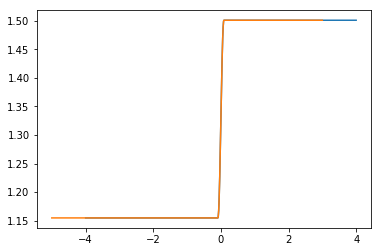

In [19]:
import numpy as np
import matplotlib.pyplot as plt

Data_numer = np.loadtxt("out1280-00002560.txt")
Data_exact = np.loadtxt("out1280-exact.txt")

mu = -0.5
gamma=1.0/np.sqrt(1-mu**2)
plt.plot(Data_numer[:,0],Data_numer[:,5])
plt.plot(Data_exact[:,0],Data_exact[:,5])
plt.plot()